In [1]:
# !pip install --upgrade scipy

In [1]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import soundfile as sf
import os 
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

In [3]:


pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = False

if on_colab:
  from google.colab import drive
  project_name = 'project_name'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './data/input/'
  output_dir = './data/output/'

os.makedirs(output_dir, exist_ok=True)



In [4]:
audio_files = os.listdir(input_dir+'audios_16khz/')
audio_files.sort()

In [5]:
# audio_files_speech = [n for n in audio_files if 'Speech_' in n]

In [70]:
import librosa

df = pd.read_csv(input_dir+'features/egemaps_vector_both.csv', index_col = 0)
display(df['token'].value_counts())
print(df.shape)

duration_d = {}

files = os.listdir(input_dir+'audios_16khz/')


for sid, token, target, filename in df[['sid', 'token','target', 'filename']].values:
    
    filename2 = filename.replace('Speech', 'Speech_') 
    
    try: 
        duration = librosa.get_duration(filename=input_dir+f'audios_16khz/{filename2}.wav', sr=16000) 
        duration_d[filename] = [sid, token, target,duration]
    except:
        print(f'{filename}.wav not found')


duration_df = pd.DataFrame(duration_d, index = ['sid', 'token', 'target', 'duration']).T

duration_df['task']  = [n[:-1] for n in duration_df['token'].values]
display(duration_df['token'].value_counts())
display(duration_df['task'].value_counts())
duration_df = duration_df.reset_index()
duration_df.columns = ['filename', 'sid', 'token', 'target', 'duration', 'task']
duration_df


Vowel1     152
Vowel3     152
Speech1    151
Speech2    151
Speech3    151
Vowel2     151
Vowel1N      1
Vowel2N      1
Vowel3N      1
Name: token, dtype: int64

(911, 92)
VFP52_Vowel1N.wav not found
VFP52_Vowel2N.wav not found
VFP52_Vowel3N.wav not found


Vowel1     152
Vowel3     152
Speech1    151
Speech2    151
Speech3    151
Vowel2     151
Name: token, dtype: int64

Vowel     455
Speech    453
Name: task, dtype: int64

,filename,sid,token,target,duration,task
0,VFP10_Speech1,VFP10,Speech1,1,3.503,Speech
1,VFP10_Speech2,VFP10,Speech2,1,3.503,Speech
2,VFP10_Speech3,VFP10,Speech3,1,3.503,Speech
3,VFP11_Speech1,VFP11,Speech1,1,3.503,Speech
4,VFP11_Speech2,VFP11,Speech2,1,3.503,Speech
...,...,...,...,...,...,...
903,VFPNorm8_Vowel2,VFPNorm8,Vowel2,0,4.109,Vowel
904,VFPNorm8_Vowel3,VFPNorm8,Vowel3,0,4.11,Vowel
905,VFPNorm9_Vowel1,VFPNorm9,Vowel1,0,4.11,Vowel
906,VFPNorm9_Vowel2,VFPNorm9,Vowel2,0,4.11,Vowel


In [93]:
means = duration_df.groupby(['task', 'target']).mean().round(2)



# stds = duration_df.groupby(['task', 'target']).std().round(2)
# display(stds)
display(means)


# duration_df[duration_df['target']==1].groupby('task')['duration'].std()

duration_df.groupby(['task', 'target'])['duration'].std()

/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


duration
task   target          
Speech 0           3.50
       1          10.25
Vowel  0           4.11
       1           3.74

task    target
Speech  0         0.000000
        1         6.168351
Vowel   0         0.064770
        1         1.300837
Name: duration, dtype: float64

In [91]:
duration_df

,filename,sid,token,target,duration,task,Group
0,VFP10_Speech1,VFP10,Speech1,1,3.503,Speech,UVFP
1,VFP10_Speech2,VFP10,Speech2,1,3.503,Speech,UVFP
2,VFP10_Speech3,VFP10,Speech3,1,3.503,Speech,UVFP
3,VFP11_Speech1,VFP11,Speech1,1,3.503,Speech,UVFP
4,VFP11_Speech2,VFP11,Speech2,1,3.503,Speech,UVFP
...,...,...,...,...,...,...,...
903,VFPNorm8_Vowel2,VFPNorm8,Vowel2,0,4.109,Vowel,Control
904,VFPNorm8_Vowel3,VFPNorm8,Vowel3,0,4.11,Vowel,Control
905,VFPNorm9_Vowel1,VFPNorm9,Vowel1,0,4.11,Vowel,Control
906,VFPNorm9_Vowel2,VFPNorm9,Vowel2,0,4.11,Vowel,Control


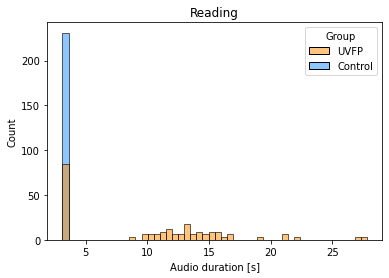

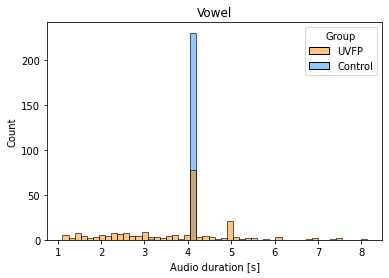

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
duration_df['Group'] = duration_df['target'].map({0: 'Control', 1: 'UVFP'})
duration_df_speech = duration_df[duration_df['task']=='Speech']
# plt.hist(x='duration', color='orange', data=duration_df_speech[duration_df_speech['Group']=='Control'], bins=50, alpha=0.5)
# plt.hist(x='duration', color='dodgerblue', data=duration_df_speech[duration_df_speech['Group']=='UVFP'], bins=50, alpha=0.5)



sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Speech'], bins=50, palette=["darkorange", "dodgerblue"])
plt.xlabel('Audio duration [s]')
# plt.axvline(x=3.5,color = 'darkorange', label = 'Mean')
# plt.legend()
plt.title('Reading')
plt.legend()
plt.savefig(output_dir+'duration_hist_speech.png', dpi=300)
plt.show()


sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Vowel'], bins=50, palette=["darkorange", "dodgerblue"])
plt.xlabel('Audio duration [s]')
plt.title('Vowel')
plt.savefig(output_dir+'duration_hist_vowel.png', dpi=300)
plt.show()

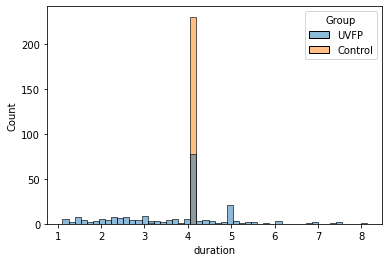

# Look at full speech files

Speech    151
Name: token, dtype: int64

Speech    151
Name: task, dtype: int64

,filename,sid,token,target,duration,task
0,VFPNorm51_Speech.wav,VFPNorm51,Speech,0,10.51,Speech
1,VFPNorm66_Speech.wav,VFPNorm66,Speech,0,10.51,Speech
2,VFPNorm33_Speech.wav,VFPNorm33,Speech,0,10.509,Speech
3,VFP58_Speech.wav,VFP58,Speech,1,10.51,Speech
4,VFPNorm18_Speech.wav,VFPNorm18,Speech,0,10.509,Speech
...,...,...,...,...,...,...
146,VFP28_Speech.wav,VFP28,Speech,1,35.953562,Speech
147,VFPNorm68_Speech.wav,VFPNorm68,Speech,0,10.51,Speech
148,VFP34_Speech.wav,VFP34,Speech,1,29.256625,Speech
149,VFP56_Speech.wav,VFP56,Speech,1,34.077438,Speech


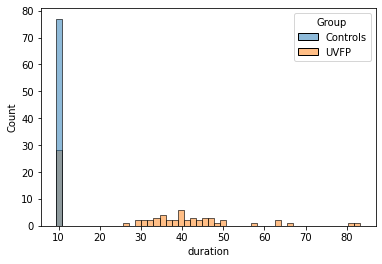

In [56]:
full_speech_files = [n for n in files if 'Speech.wav' in n]
duration_d = {}

for filename in full_speech_files:
    duration = librosa.get_duration(filename=input_dir+f'audios_16khz/{filename}', sr=16000) 
    sid = filename.split('_')[0]
    token = filename.split('_')[1]
    token = token.replace('.wav', '')
    if 'VFPNorm' in filename:
        target = 0
    else:
        target = 1
    
    duration_d[filename] = [sid, token, target,duration]


duration_df = pd.DataFrame(duration_d, index = ['sid', 'token', 'target', 'duration']).T

duration_df['task']  = duration_df['token'].values
display(duration_df['token'].value_counts())
display(duration_df['task'].value_counts())
duration_df = duration_df.reset_index()
duration_df.columns = ['filename', 'sid', 'token', 'target', 'duration', 'task']
display(duration_df)


duration_df['Group'] = duration_df['target'].map({0: 'Controls', 1: 'UVFP'})
sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Speech'], bins=50)


plt.show()

# sns.histplot(x='duration', hue='Group', data=duration_df[duration_df['task']=='Vowel'], bins=100)
# plt.show()




In [ ]:
import librosa

df = pd.read_csv(input_dir+'features/egemaps_vector_both.csv', index_col = 0)
display(df['token'].value_counts())
print(df.shape)

duration_d = {}

files = os.listdir(input_dir+'audios_16khz/')



for sid, token, target, filename in df[['sid', 'token','target', 'filename']].values:
    
    filename2 = filename.replace('Speech', 'Speech_') 
    
    try: 
        duration = librosa.get_duration(filename=input_dir+f'audios_16khz/{filename2}.wav', sr=16000) 
        duration_d[filename] = [sid, token, target,duration]
    except:
        print(f'{filename}.wav not found')


duration_df = pd.DataFrame(duration_d, index = ['sid', 'token', 'target', 'duration']).T

duration_df['task']  = [n[:-1] for n in duration_df['token'].values]
display(duration_df['token'].value_counts())
display(duration_df['task'].value_counts())
duration_df = duration_df.reset_index()
duration_df.columns = ['filename', 'sid', 'token', 'target', 'duration', 'task']
duration_df


### Add to egemaps features DF

In [20]:
# egemaps features
egemaps_filenames = ['egemaps_vector_both.csv',
                    'egemaps_vector_speech.csv',
                    'egemaps_vector_vowel.csv'
                   ]

egemaps_features_df = {}
for i in egemaps_filenames:
    df_i = pd.read_csv(input_dir+'features/'+i, index_col = 0)
    egemaps_features_df[i]=df_i
    

In [26]:
duration_df

,filename,sid,token,target,duration,task
0,VFP10_Speech_1,VFP10,Speech1,1,3.503,Speech
1,VFP10_Speech_2,VFP10,Speech2,1,3.503,Speech
2,VFP10_Speech_3,VFP10,Speech3,1,3.503,Speech
3,VFP11_Speech_1,VFP11,Speech1,1,3.503,Speech
4,VFP11_Speech_2,VFP11,Speech2,1,3.503,Speech
...,...,...,...,...,...,...
903,VFPNorm8_Vowel2,VFPNorm8,Vowel2,0,4.109,Vowel
904,VFPNorm8_Vowel3,VFPNorm8,Vowel3,0,4.11,Vowel
905,VFPNorm9_Vowel1,VFPNorm9,Vowel1,0,4.11,Vowel
906,VFPNorm9_Vowel2,VFPNorm9,Vowel2,0,4.11,Vowel


,sid,token,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,logRelF0-H1-H2_sma3nz_amean,logRelF0-H1-H2_sma3nz_stddevNorm,logRelF0-H1-A3_sma3nz_amean,logRelF0-H1-A3_sma3nz_stddevNorm,F1frequency_sma3nz_amean,F1frequency_sma3nz_stddevNorm,F1bandwidth_sma3nz_amean,F1bandwidth_sma3nz_stddevNorm,F1amplitudeLogRelF0_sma3nz_amean,F1amplitudeLogRelF0_sma3nz_stddevNorm,F2frequency_sma3nz_amean,F2frequency_sma3nz_stddevNorm,F2bandwidth_sma3nz_amean,F2bandwidth_sma3nz_stddevNorm,F2amplitudeLogRelF0_sma3nz_amean,F2amplitudeLogRelF0_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,F3amplitudeLogRelF0_sma3nz_amean,F3amplitudeLogRelF0_sma3nz_stddevNorm,alphaRatioV_sma3nz_amean,alphaRatioV_sma3nz_stddevNorm,hammarbergIndexV_sma3nz_amean,hammarbergIndexV_sma3nz_stddevNorm,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,mfcc1V_sma3nz_amean,mfcc1V_sma3nz_stddevNorm,mfcc2V_sma3nz_amean,mfcc2V_sma3nz_stddevNorm,mfcc3V_sma3nz_amean,mfcc3V_sma3nz_stddevNorm,mfcc4V_sma3nz_amean,mfcc4V_sma3nz_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,target,filename,duration,task
0,VFP10,Vowel1,40.6,0.00520,40.4,40.6,40.8,0.349,5.28,2.410,5.32,3.74,1.090,0.0872,1.010,1.090,1.170,0.1630,1.620,0.744,1.330,0.649,0.1330,0.426,22.9,0.1190,-21.70,-0.148,-23.00,-0.300,-12.10,-0.445,0.00363,0.412,0.252,0.301,14.70,0.0487,-4.5500,-0.245,9.63,0.506,614.0,0.2420,1260.0,0.1380,-0.20,-11.100,1460.0,0.0710,942.0,0.0741,2.27,0.678,2700.0,0.0312,429.0,0.425,-12.6,-0.3590,0.6500,1.620,14.4,0.2630,0.01040,1.660,0.010400,0.224,0.1340,0.425,22.9,0.1190,-21.70,-0.149,-22.90,-0.303,-12.10,-0.446,0.00,0.0,0.000000,0.00000,0.0000,4.16,0.248,4.020,0.000,0.0000,0.0000,-31.5,1,VFP10_Vowel1,4.109,Vowel
1,VFP10,Vowel2,39.0,0.00468,38.9,39.0,39.2,0.309,4.50,1.950,4.77,2.15,0.699,0.0725,0.655,0.692,0.744,0.0881,1.210,0.550,1.360,0.639,0.0891,0.279,29.4,0.0754,-13.50,-0.164,-19.20,-0.168,-7.53,-0.533,0.00460,0.384,0.378,0.383,13.50,0.0371,1.8600,0.342,19.10,0.120,462.0,0.3720,1660.0,0.1790,-4.27,-0.653,1310.0,0.1060,1040.0,0.0947,2.37,1.280,2590.0,0.0720,760.0,0.250,-22.8,-0.1270,1.4400,0.731,23.9,0.1300,0.01080,1.640,-0.000335,-6.470,0.0895,0.275,29.4,0.0755,-13.50,-0.163,-19.20,-0.169,-7.46,-0.536,0.00,0.0,0.000000,0.00000,0.0000,7.33,0.248,4.020,0.000,0.0000,0.0000,-36.0,1,VFP10_Vowel2,4.109,Vowel
2,VFP10,Vowel3,39.4,0.00475,39.2,39.3,39.5,0.296,5.33,2.610,4.86,1.87,0.789,0.0637,0.751,0.794,0.831,0.0802,1.450,0.765,1.480,0.611,0.1090,0.245,28.0,0.0798,-13.60,-0.226,-24.60,-0.144,-6.95,-0.513,0.00523,

In [33]:
for filename, df_i in egemaps_features_df.items():
    df_i_duration = df_i.merge(duration_df[['filename', 'duration', 'task']], on = ['filename'], how='inner')
    df_i_duration.to_csv(input_dir+'features/'+filename.replace('.csv', '_duration.csv'))
    
    

In [39]:
df_i_duration.columns.tolist()

['sid',
 'token',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_std

# Bootstrapping classification

In [35]:

models = [
    LogisticRegressionCV(solver='liblinear', penalty = 'l1', max_iter = 100),
    SGDClassifier(loss='log', penalty="elasticnet", early_stopping=True, max_iter = 5000),
    MLPClassifier(alpha = 1, max_iter= 1000),
    RandomForestClassifier(n_estimators= 100)
]


names = ['LogisticRegressionCV', 'SGDClassifier', "MLPClassifier","RandomForestClassifier"]

In [43]:
%%time

toy = False


os.makedirs(output_dir+f'duration/', exist_ok=True)

for df_name, task_type_df in zip(['speech', 'vowel', 'both'], [
    'egemaps_vector_speech_duration.csv',
    'egemaps_vector_vowel_duration.csv', 
    'egemaps_vector_both_duration.csv']):
    duration_df = pd.read_csv(input_dir+f'features/{task_type_df}', index_col = 0)
    print(df_name, '\n====')

    for null_model in [True, False]:
        print('\npermute', null_model)
    
        if toy:
          n_bootstraps = 3
        else:
          n_bootstraps = 50

        # bs = cross_validation.Bootstrap(len(y), n_bootstraps=n_bootstraps, random_state=123,n_test = 0.2) # or add source code


        variables = ['duration']
        X = duration_df[variables].values
        y = duration_df['target'].values
        if null_model:
            y = np.random.permutation(y) #CHECK
        groups = duration_df['sid'].values

        y_pred_all = {}
        roc_auc_all = {}
        for model, name in zip(models, names):
          y_pred_all[name] = []
          roc_auc_all[name] = []
          pipe = Pipeline(steps=[
                  ('scaler', StandardScaler()), 
                  ('model', model)])

          ## Performing bootstrapping
          for i in range(n_bootstraps):
              #Split the data into training and testing set
              from sklearn.model_selection import train_test_split
              # Chaning the seed value for each iteration
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)

          # for train_index, test_index in bs:
          #   X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
              pipe.fit(X_train,y_train)

              # Test     
              y_pred = pipe.predict(X_test)
              roc_auc = roc_auc_score(y_test,y_pred)
              # print(name, roc_auc)
              y_pred_all[name].append(y_pred)
              roc_auc_all[name].append(roc_auc)

        results_i = []
        for name in ['LogisticRegressionCV','MLPClassifier','RandomForestClassifier','SGDClassifier']:
          scores = roc_auc_all.get(name)
          roc_auc_median = np.round(np.median(scores),2)
          roc_auc_5 = np.round(np.percentile(scores, 5),2)
          roc_auc_95 = np.round(np.percentile(scores, 95),2)
          results_str = f'{roc_auc_median} ({roc_auc_5}–{roc_auc_95}; )'
          results_str = results_str.replace('0.', '.')
          results_i.append([name, results_str])
            
          if null_model:
            print(name, str(roc_auc_median).replace('0.', '.'))
        if not null_model:
            results_i_df = pd.DataFrame(results_i, ).T
            display(results_i_df)

            results_i_df.to_csv(output_dir+f'duration/results_duration_{df_name}_permute-{null_model}.csv')

            
                

        # pd.DataFrame(y_pred_all)


speech 
====

permute True
LogisticRegressionCV .5
MLPClassifier .52
RandomForestClassifier .52
SGDClassifier .5

permute False


/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/

,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.82 (.75–.86; ),.82 (.75–.86; ),.85 (.8–.89; ),.81 (.5–.86; )


vowel 
====

permute True
LogisticRegressionCV .5
MLPClassifier .55
RandomForestClassifier .57
SGDClassifier .5

permute False


,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.7 (.65–.75; ),.8 (.76–.86; ),.86 (.82–.9; ),.53 (.34–.72; )


both 
====

permute True
LogisticRegressionCV .5
MLPClassifier .5
RandomForestClassifier .51
SGDClassifier .5

permute False


,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.7 (.67–.74; ),.76 (.72–.8; ),.86 (.83–.89; ),.63 (.47–.69; )


CPU times: user 2min 22s, sys: 2min 43s, total: 5min 6s
Wall time: 1min 14s
